In [1]:

import numpy as np
import os
import imageio
import torch
import cv2

from utils_road import load_config, create_output_dir_and_save_config
from dataset import cityscale_data_partition, read_rgb_img, get_patch_info_one_img
from dataset import spacenet_data_partition
from model import SAMRoad
import graph_extraction
import graph_utils
import triage
import pickle
import scipy
import rtree
from collections import defaultdict
import time
import PIL

from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

import json

In [2]:
def get_img_paths(root_dir, image_indices):
    img_paths = []

    for ind in image_indices:
        img_paths.append(os.path.join(root_dir, f"region_{ind}_sat.png"))

    return img_paths

def overlay_mask_on_image(img, road_mask, color=(0, 0, 255), alpha=0.5, th =100):
    # Ensure the mask has the same shape as the image
    if img.shape[:2] != road_mask.shape:
        road_mask = cv2.resize(road_mask, (img.shape[1], img.shape[0]))
    
    # Create a color version of the mask with the desired color
    # Mask values should be 0 or 1 (binary)
    color_mask = np.zeros_like(img)
    color_mask[:, :] = color  # Fill with the desired color
    
    # Convert the grayscale mask to a binary mask where non-zero values are 1
    binary_mask = road_mask > th
    
    # Create the final colored mask using the binary mask
    color_mask = np.where(binary_mask[:, :, None], color_mask, 0)

    # Overlay the colored mask on the original image using alpha blending
    overlayed_image = cv2.addWeighted(img, 1 - alpha, color_mask, alpha, 0)
    
    return overlayed_image


def crop_img_patch(img, x0, y0, x1, y1):
    return img[y0:y1, x0:x1, :]


def get_batch_img_patches(img, batch_patch_info):
    patches = []
    for _, (x0, y0), (x1, y1) in batch_patch_info:
        patch = crop_img_patch(img, x0, y0, x1, y1)
        patches.append(torch.tensor(patch, dtype=torch.float32))
    batch = torch.stack(patches, 0).contiguous()
    return batch


def infer_one_img(net, img, config, device='cuda'):
    # TODO(congrui): centralize these configs
    image_size = img.shape[0]

    batch_size = config.INFER_BATCH_SIZE
    # list of (i, (x_begin, y_begin), (x_end, y_end))
    all_patch_info = get_patch_info_one_img(
        0, image_size, config.SAMPLE_MARGIN, config.PATCH_SIZE, config.INFER_PATCHES_PER_EDGE)
    patch_num = len(all_patch_info)
    batch_num = (
        patch_num // batch_size
        if patch_num % batch_size == 0
        else patch_num // batch_size + 1
    )

    

    # [IMG_H, IMG_W]
    fused_keypoint_mask = torch.zeros(img.shape[0:2], dtype=torch.float32).to(device, non_blocking=False)
    fused_road_mask = torch.zeros(img.shape[0:2], dtype=torch.float32).to(device, non_blocking=False)
    pixel_counter = torch.zeros(img.shape[0:2], dtype=torch.float32).to(device, non_blocking=False)

    # stores img embeddings for toponet
    # list of [B, D, h, w], len=batch_num
    img_features = list()

    for batch_index in range(batch_num):
        offset = batch_index * batch_size
        batch_patch_info = all_patch_info[offset : offset + batch_size]
        # tensor [B, H, W, C]
        batch_img_patches = get_batch_img_patches(img, batch_patch_info)

        with torch.no_grad():
            batch_img_patches = batch_img_patches.to(device, non_blocking=False)
            # [B, H, W, 2]
            mask_scores, patch_img_features = net.infer_masks_and_img_features(batch_img_patches)
            img_features.append(patch_img_features)
        # Aggregate masks
        for patch_index, patch_info in enumerate(batch_patch_info):
            _, (x0, y0), (x1, y1) = patch_info
            keypoint_patch, road_patch = mask_scores[patch_index, :, :, 0], mask_scores[patch_index, :, :, 1]
            fused_keypoint_mask[y0:y1, x0:x1] += keypoint_patch
            fused_road_mask[y0:y1, x0:x1] += road_patch
            pixel_counter[y0:y1, x0:x1] += torch.ones(road_patch.shape[0:2], dtype=torch.float32, device=device)
    
    fused_keypoint_mask /= pixel_counter
    fused_road_mask /= pixel_counter
    # range 0-1 -> 0-255
    fused_keypoint_mask = (fused_keypoint_mask * 255).to(torch.uint8).cpu().numpy()
    fused_road_mask = (fused_road_mask * 255).to(torch.uint8).cpu().numpy()

    # ## Astar graph extraction
    # pred_graph = graph_extraction.extract_graph_astar(fused_keypoint_mask, fused_road_mask, config)
    # # Doing this conversion to reuse copied code
    # pred_nodes, pred_edges = graph_utils.convert_from_nx(pred_graph)
    # return pred_nodes, pred_edges, fused_keypoint_mask, fused_road_mask
    # ## Astar graph extraction
    
    
    ## Extract sample points from masks
    graph_points = graph_extraction.extract_graph_points(fused_keypoint_mask, fused_road_mask, config)
    if graph_points.shape[0] == 0:
        return graph_points, np.zeros((0, 2), dtype=np.int32), fused_keypoint_mask, fused_road_mask

    # for box query
    graph_rtree = rtree.index.Index()
    for i, v in enumerate(graph_points):
        x, y = v
        # hack to insert single points
        graph_rtree.insert(i, (x, y, x, y))
    
    ## Pass 2: infer toponet to predict topology of points from stored img features
    edge_scores = defaultdict(float)
    edge_counts = defaultdict(float)
    for batch_index in range(batch_num):
        offset = batch_index * batch_size
        batch_patch_info = all_patch_info[offset : offset + batch_size]

        topo_data = {
            'points': [],
            'pairs': [],
            'valid': [],
        }
        idx_maps = []


        # prepares pairs queries
        for patch_info in batch_patch_info:
            _, (x0, y0), (x1, y1) = patch_info
            patch_point_indices = list(graph_rtree.intersection((x0, y0, x1, y1)))
            idx_patch2all = {patch_idx : all_idx for patch_idx, all_idx in enumerate(patch_point_indices)}
            patch_point_num = len(patch_point_indices)
            # normalize into patch
            patch_points = graph_points[patch_point_indices, :] - np.array([[x0, y0]], dtype=graph_points.dtype)
            # for knn and circle query
            patch_kdtree = scipy.spatial.KDTree(patch_points)

            # k+1 because the nearest one is always self
            # idx is to the patch subgraph
            knn_d, knn_idx = patch_kdtree.query(patch_points, k=config.MAX_NEIGHBOR_QUERIES + 1, distance_upper_bound=config.NEIGHBOR_RADIUS)
            # [patch_point_num, n_nbr]
            knn_idx = knn_idx[:, 1:]  # removes self
            # [patch_point_num, n_nbr] idx is to the patch subgraph
            src_idx = np.tile(
                np.arange(patch_point_num)[:, np.newaxis],
                (1, config.MAX_NEIGHBOR_QUERIES)
            )
            valid = knn_idx < patch_point_num
            tgt_idx = np.where(valid, knn_idx, src_idx)
            # [patch_point_num, n_nbr, 2]
            pairs = np.stack([src_idx, tgt_idx], axis=-1)

            topo_data['points'].append(patch_points)
            topo_data['pairs'].append(pairs)
            topo_data['valid'].append(valid)
            idx_maps.append(idx_patch2all)
        
        # collate
        collated = {}
        for key, x_list in topo_data.items():
            length = max([x.shape[0] for x in x_list])
            collated[key] = np.stack([
                np.pad(x, [(0, length - x.shape[0])] + [(0, 0)] * (len(x.shape) - 1))
                for x in x_list
            ], axis=0)

        # skips this batch if there's no points
        if collated['points'].shape[1] == 0:
            continue
        
        # infer toponet
        # [B, D, h, w]
        batch_features = img_features[batch_index]
        # [B, N_sample, N_pair, 2]
        batch_points = torch.tensor(collated['points'], device=device)
        batch_pairs = torch.tensor(collated['pairs'], device=device)
        batch_valid = torch.tensor(collated['valid'], device=device)


        with torch.no_grad():
            # [B, N_samples, N_pairs, 1]
            topo_scores = net.infer_toponet(batch_features, batch_points, batch_pairs, batch_valid)
                
        # all-invalid (padded, no neighbors) queries returns nan scores
        # [B, N_samples, N_pairs]
        topo_scores = torch.where(torch.isnan(topo_scores), -100.0, topo_scores).squeeze(-1).cpu().numpy()

        # aggregate edge scores
        batch_size, n_samples, n_pairs = topo_scores.shape
        for bi in range(batch_size):
            for si in range(n_samples):
                for pi in range(n_pairs):
                    if not collated['valid'][bi, si, pi]:
                        continue
                    # idx to the full graph
                    src_idx_patch, tgt_idx_patch = collated['pairs'][bi, si, pi, :]
                    src_idx_all, tgt_idx_all = idx_maps[bi][src_idx_patch], idx_maps[bi][tgt_idx_patch]
                    edge_score = topo_scores[bi, si, pi]
                    assert 0.0 <= edge_score <= 1.0
                    edge_scores[(src_idx_all, tgt_idx_all)] += edge_score
                    edge_counts[(src_idx_all, tgt_idx_all)] += 1.0

    # avg edge scores and filter
    pred_edges = []
    for edge, score_sum in edge_scores.items():
        score = score_sum / edge_counts[edge] 
        if score > config.TOPO_THRESHOLD:
            pred_edges.append(edge)
    pred_edges = np.array(pred_edges).reshape(-1, 2)
    pred_nodes = graph_points[:, ::-1]  # to rc
    
    

    return pred_nodes, pred_edges, fused_keypoint_mask, fused_road_mask

def load_sam_road(config_file, check_point, device):
    config = load_config(config_file)
    
    # Builds eval model    
    device = torch.device(device)#
    # Good when model architecture/input shape are fixed.
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True
    net = SAMRoad(config)

    checkpoint = torch.load(check_point, map_location=device)
    net.load_state_dict(checkpoint["state_dict"], strict=True)
    net.eval()
    net.to(device)
    
    return net, config

In [3]:
config_dir = "/home/kt/python/sam_road/config/"
sam_road_checkpoint = "/home/datadisk/evaluation/models/SAM/SAM-road/"
net_cityscale, config_cityscale = load_sam_road(f"{config_dir}toponet_vitb_512_cityscale.yaml", f"{sam_road_checkpoint}cityscale_vitb_512_e10.ckpt", "cuda")
net_spacenet, config_spacenet = load_sam_road(f"{config_dir}toponet_vitb_256_spacenet.yaml", f"{sam_road_checkpoint}spacenet_vitb_256_e10.ckpt", "cuda")


/home/kt/python/data_engineer/sam_road/model.py:368: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_state_dict = torch.load(f)


###### Matched params ######
['image_encoder.pos_embed',
 'image_encoder.patch_embed.proj.weight',
 'image_encoder.patch_embed.proj.bias',
 'image_encoder.blocks.0.norm1.weight',
 'image_encoder.blocks.0.norm1.bias',
 'image_encoder.blocks.0.attn.rel_pos_h',
 'image_encoder.blocks.0.attn.rel_pos_w',
 'image_encoder.blocks.0.attn.qkv.weight',
 'image_encoder.blocks.0.attn.qkv.bias',
 'image_encoder.blocks.0.attn.proj.weight',
 'image_encoder.blocks.0.attn.proj.bias',
 'image_encoder.blocks.0.norm2.weight',
 'image_encoder.blocks.0.norm2.bias',
 'image_encoder.blocks.0.mlp.lin1.weight',
 'image_encoder.blocks.0.mlp.lin1.bias',
 'image_encoder.blocks.0.mlp.lin2.weight',
 'image_encoder.blocks.0.mlp.lin2.bias',
 'image_encoder.blocks.1.norm1.weight',
 'image_encoder.blocks.1.norm1.bias',
 'image_encoder.blocks.1.attn.rel_pos_h',
 'image_encoder.blocks.1.attn.rel_pos_w',
 'image_encoder.blocks.1.attn.qkv.weight',
 'image_encoder.blocks.1.attn.qkv.bias',
 'image_encoder.blocks.1.attn.proj.we

/tmp/ipykernel_181285/3008055645.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(check_point, map_location=device)


###### Matched params ######
['image_encoder.pos_embed',
 'image_encoder.patch_embed.proj.weight',
 'image_encoder.patch_embed.proj.bias',
 'image_encoder.blocks.0.norm1.weight',
 'image_encoder.blocks.0.norm1.bias',
 'image_encoder.blocks.0.attn.rel_pos_h',
 'image_encoder.blocks.0.attn.rel_pos_w',
 'image_encoder.blocks.0.attn.qkv.weight',
 'image_encoder.blocks.0.attn.qkv.bias',
 'image_encoder.blocks.0.attn.proj.weight',
 'image_encoder.blocks.0.attn.proj.bias',
 'image_encoder.blocks.0.norm2.weight',
 'image_encoder.blocks.0.norm2.bias',
 'image_encoder.blocks.0.mlp.lin1.weight',
 'image_encoder.blocks.0.mlp.lin1.bias',
 'image_encoder.blocks.0.mlp.lin2.weight',
 'image_encoder.blocks.0.mlp.lin2.bias',
 'image_encoder.blocks.1.norm1.weight',
 'image_encoder.blocks.1.norm1.bias',
 'image_encoder.blocks.1.attn.rel_pos_h',
 'image_encoder.blocks.1.attn.rel_pos_w',
 'image_encoder.blocks.1.attn.qkv.weight',
 'image_encoder.blocks.1.attn.qkv.bias',
 'image_encoder.blocks.1.attn.proj.we

In [9]:
file_path = "/home/datadisk2/JSON/dataset1_JSON/new_format/million-AID/train.json"
# Load the JSON file
with open(file_path, 'r') as f:
    json_data = json.load(f)

data = json_data['data']

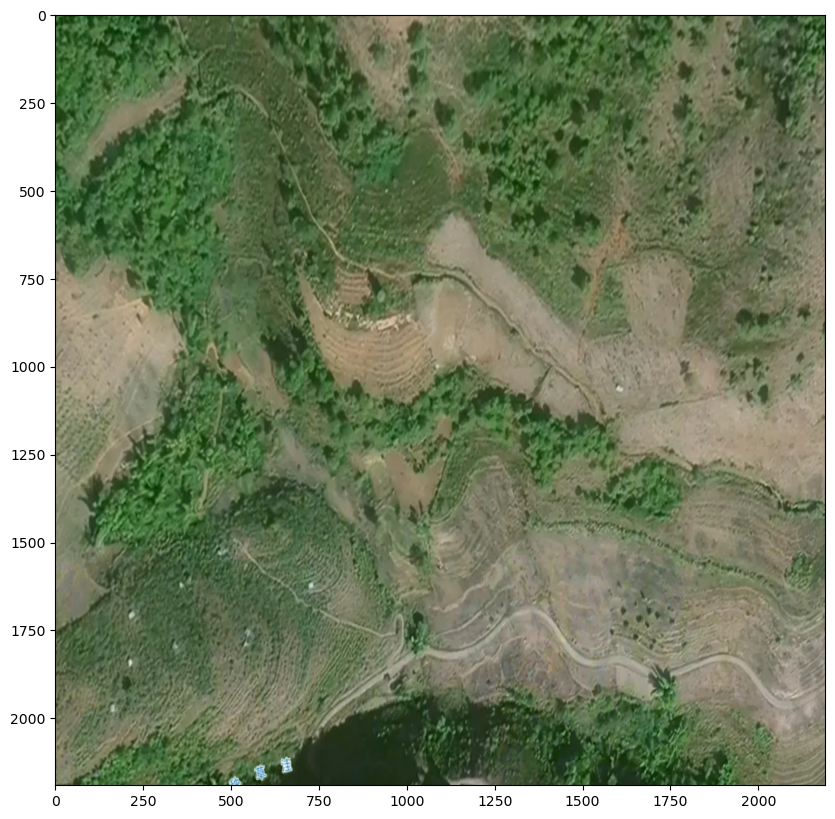

In [25]:
index = 8004

#output_dir_prefix = './save/infer_'
#output_dir = create_output_dir_and_save_config(output_dir_prefix, config)
dir = "/home/oss/Datasets/"
dir =  "/home/datadisk/xyy/Projects/testData/RoadSeg/"
file_name = "RoadSeg4.png"#data[index]['image'][0]

image = cv2.imread(f'{dir}{file_name}')
image_source = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_source = resized_to_original = cv2.resize(image_source, (image_source.shape[1], image_source.shape[1]), interpolation=cv2.INTER_AREA)
plt.figure(figsize=(10, 10))
plt.imshow(image_source)
plt.show()

In [26]:
total_inference_seconds = 0.0
img = read_rgb_img(f'{dir}{file_name}')
start_seconds = time.time()
# coords in (r, c)

img = resized_to_original = cv2.resize(img, (img.shape[1], img.shape[1]), interpolation=cv2.INTER_AREA)



pred_nodes_spacenet, pred_edges_spacenet, itsc_mask_spacenet, road_mask_spacenet = infer_one_img(net_spacenet, img, config_spacenet)
#pred_nodes_cityscale, pred_edges_cityscale, itsc_mask_cityscale, road_mask_cityscale = infer_one_img(net_cityscale, img, config_cityscale)

end_seconds = time.time()

In [27]:

input_label = np.ones(len(pred_nodes_spacenet), dtype = int)

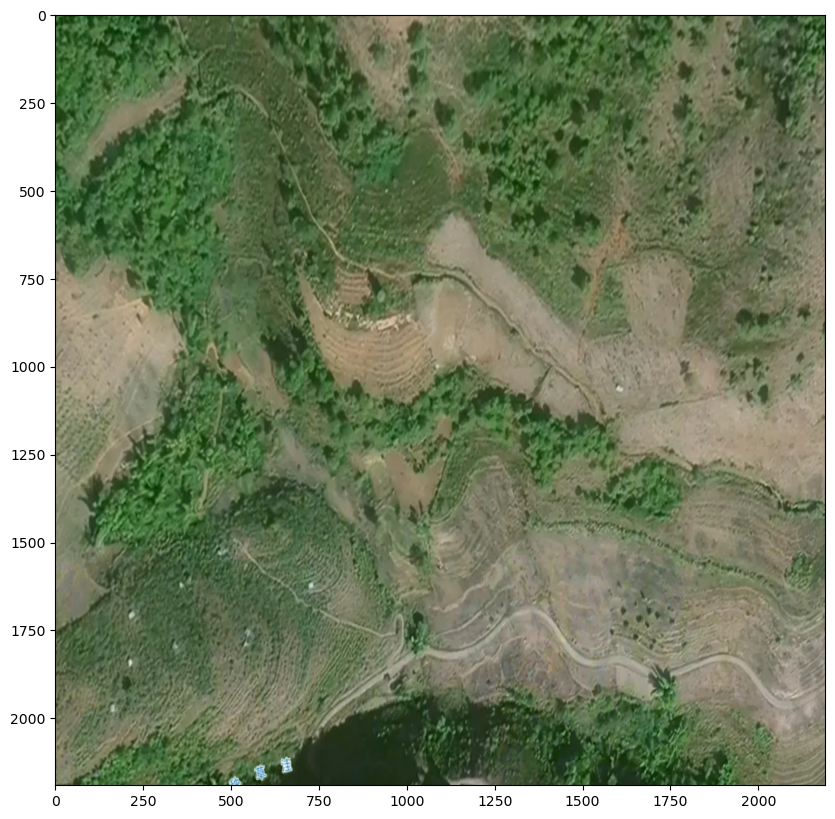

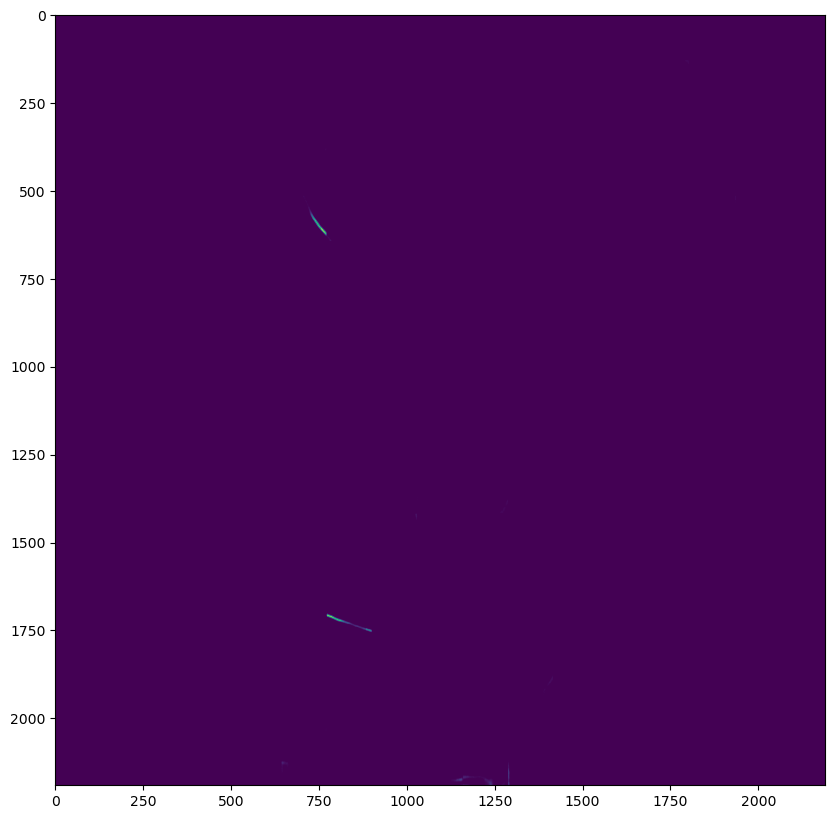

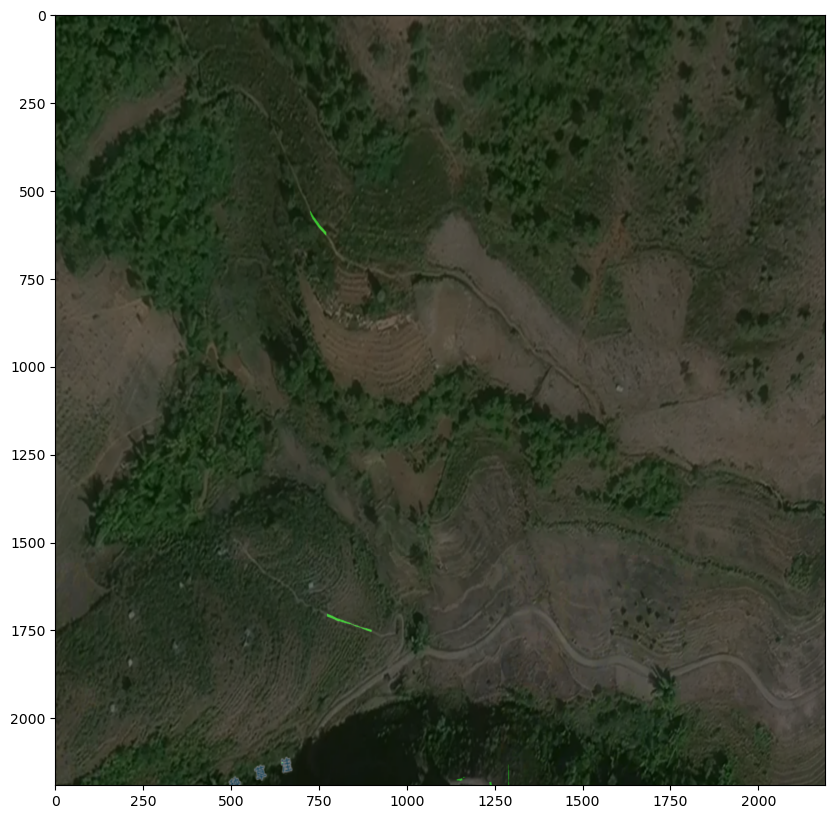

In [28]:

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()
plt.figure(figsize=(10, 10))
plt.imshow(road_mask_spacenet)
plt.show()

overlay_image = overlay_mask_on_image(img, road_mask_spacenet, color=(0, 255, 0), alpha=0.5,th=5)
plt.figure(figsize=(10, 10))
#for (x,y) in pred_nodes_spacenet:
#    plt.plot(y, x, marker='o', color="red") 
plt.imshow(overlay_image)
plt.show()

#plt.figure(figsize=(10, 10))
#plt.imshow(road_mask_cityscale)
#plt.show()
#overlay_mask_on_image(img, road_mask_cityscale, color=(0, 255, 0), alpha=0.2,th=40)

In [189]:
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/home/datadisk/evaluation/models/SAM/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)




/home/kt/python/sam_road/sam/segment-anything/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [190]:
predictor.set_image(img)

In [196]:

masks, scores, logits = predictor.predict(
    point_coords=pred_nodes_spacenet,
    point_labels=input_label,
    multimask_output=True,
)

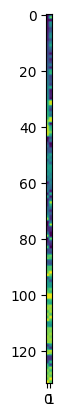

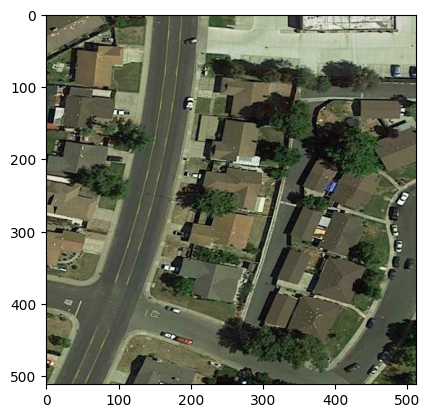

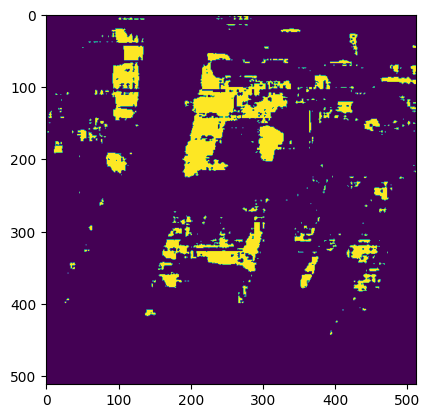

In [217]:

plt.imshow(pred_edges_spacenet)
plt.show()
plt.imshow(img)
plt.show()
plt.imshow(masks[1])
plt.show()

TypeError: Invalid shape (3, 512, 512) for image data

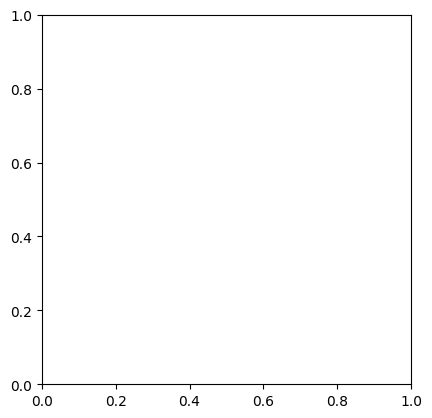

In [199]:
for i in range(img.shape[0]):
    for j in range(img.shape[1]):
        try:
            if masks[over_y + i, over_x + j]:
                existing_pixel = gt_image[over_y + i, over_x + j].astype(float)
                blended_pixel = (1 - alpha) * existing_pixel + alpha * random_color
                gt_image[over_y + i, over_x + j] = np.clip(blended_pixel, 0, 255).astype(np.uint8)
        except Exception as e:
            continue

plt.imshow(cropped_gt)
plt.show()

In [90]:
import cv2
import numpy as np

def overlay_mask_on_image(img, road_mask, alpha=0.5):
    
    
    # Overlay the mask on the original image using alpha blending
    overlayed_image = cv2.addWeighted(img, 1 - alpha, road_mask, alpha, 0)
    
    # Display the result
    cv2.imshow('Overlayed Image', overlayed_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # Save the overlayed image (optional)
    cv2.imwrite('overlayed_image.png', overlayed_image)

# Example usage:
overlay_mask_on_image(img, road_mask, alpha=0.5)

error: OpenCV(4.10.0) /io/opencv/modules/core/src/arithm.cpp:658: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


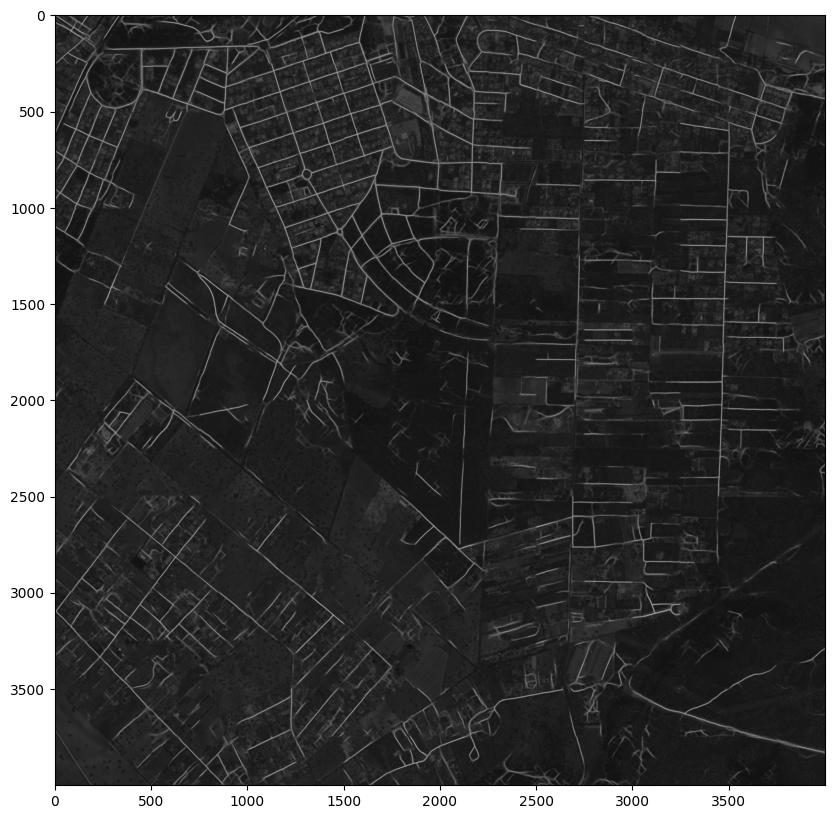

In [9]:
import cv2
import numpy as np

def overlay_mask_on_image(img, road_mask, alpha=0.5):
    # Ensure the mask has the same shape as the image
    if img.shape[:2] != road_mask.shape:
        road_mask = cv2.resize(road_mask, (img.shape[1], img.shape[0]))

    # Convert the mask to 3-channel (if it's grayscale)
    if len(road_mask.shape) == 2:
        road_mask_colored = cv2.cvtColor(road_mask, cv2.COLOR_GRAY2BGR)
    else:
        road_mask_colored = road_mask
    
    # Normalize the mask to range [0, 1] if its values are between 0-255
    road_mask_normalized = road_mask_colored / 255.0
    
    # Overlay the mask on the original image using alpha blending
    overlayed_image = cv2.addWeighted(img, 1 - alpha, road_mask_colored, alpha, 0)
    
    # Display the result

    plt.figure(figsize=(10, 10))
    plt.imshow(overlayed_image)
    plt.show()
    
    # Save the overlayed image (optional)
    #cv2.imwrite('overlayed_image.png', overlayed_image)

# Example usage:
# Assuming 'img' and 'road_mask' are loaded using cv2.imread

overlay_mask_on_image(img, road_mask, alpha=0.5)

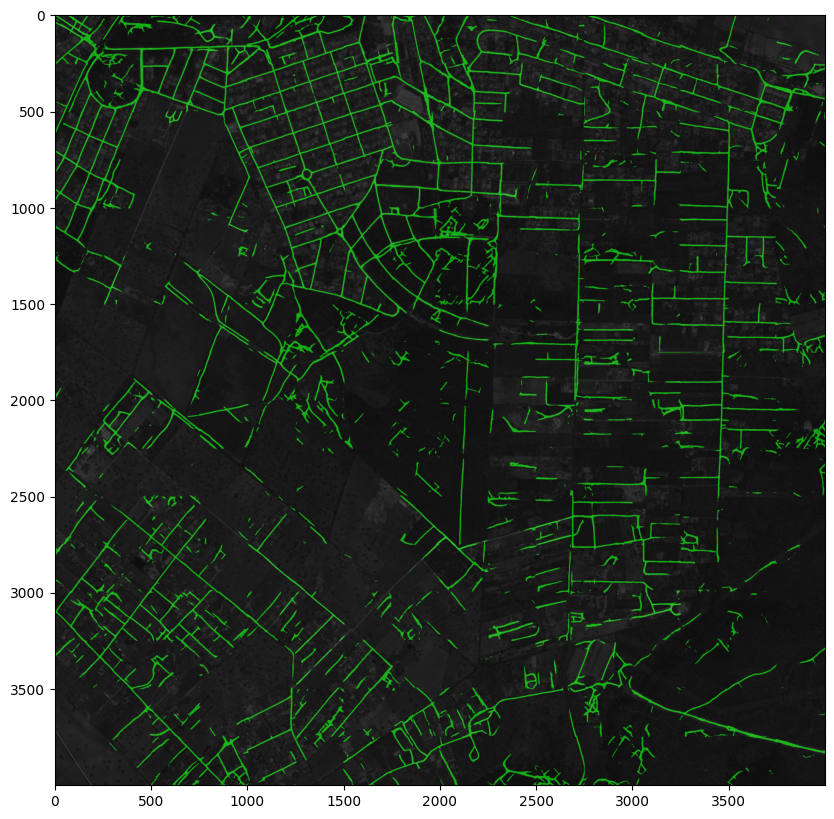

In [23]:
import cv2
import numpy as np



# Example usage:


Average Precision (AP): 0.6450
